### Read Data

In [11]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
from matplotlib import pyplot as plt 

In [2]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
clean_data = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/zhiliny/final_project4')

22/12/08 02:01:38 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
clean_data = clean_data.drop\
('follower_count','favorite_count')

In [5]:
cleandata1 = clean_data.withColumn('description',clean_data.user['description'])
cleandata1 = cleandata1.withColumn('verified_user',clean_data.user['verified']).\
                        withColumn('follower_counted',clean_data.user['followers_count']).\
                        withColumn('usersid',clean_data.user['id']).\
                        withColumn('retweetcount',cleandata1.retweeted_status['retweet_count']).\
                        withColumn('quotecount',cleandata1.retweeted_status['quote_count']).\
                        withColumn('favourite_count',cleandata1.retweeted_status['favorite_count'].cast(IntegerType())).\
                        withColumn('userid1',cleandata1.retweeted_status['id']).\
                        withColumn('country',clean_data['country'])


# cleandata1.limit(1).toPandas()

In [6]:
## Categorize the Twitterers' organizations by searching the keywords
## If the follower count is larger than 10000, I categorize the user as a 'social media Influncer'
government_entities=['[Gg]overnment','[Ss]tate','[Ff]ederal','[Cc]ongress','[Ss]enate','[Ss]enator',
                    '[Cc]ongressman','[Cc]ongresswoman','[Mm]ayor']
universities=['[Uu]niversit(y)?(ies)?','[Cc]olleg(e)?(es)','[Hh]igher [Ed]ucation','[Aa]cadamy','[Ii]nstitution']
schools=['[Ss]chool(s)?','[Pp]rimary [Ss]chool', '[Ss]econdary [Ss]chool','[Hh]igh [Ss]chool']
nonprofit_organizations = ['[Nn]onprofit','NGO','[Ff]oundation(s)?','[Nn]onprofit [Oo]rganization(s)?']
news_outlets=['[Nn]ewsletter(s)?','[Nn]ewspaper(s)?','[Jj]ournal(s)?','[Nn]ews']
social_media=['[Ff]acebook','[Ii]nstagram','[Ss]ocial [Mm]edia']

cleandata1 = cleandata1.withColumn('Twitterer_category',\
                    when(cleandata1.description.rlike('|'.join(government_entities)),'Government').\
                    when(cleandata1.description.rlike('|'.join(universities)),'Universities').\
                    when(cleandata1.description.rlike('|'.join(schools)),'Schools').\
                    when(cleandata1.description.rlike('|'.join(nonprofit_organizations)),'Nonprofit').\
                    when(cleandata1.description.rlike('|'.join(news_outlets)),'News').\
                    when(cleandata1.follower_counted>=10000,'Influencer').\
                    otherwise('Someone else'))

### Twitterer Organization Analysis--Author identification

#### By Tweets

In [64]:
category = cleandata1.groupby('Twitterer_category').\
                      agg(count('*').alias('cat_count')).\
                      orderBy('cat_count', ascending=False)

In [65]:
category = category.toPandas()

In [66]:
category

,Twitterer_category,cat_count
0,Someone else,913545
1,Influencer,43678
2,News,30412
3,Government,24542
4,Schools,24177
5,Universities,13449
6,Nonprofit,2674


##### Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Influencer'),
  Text(1, 0, 'News'),
  Text(2, 0, 'Government'),
  Text(3, 0, 'Schools'),
  Text(4, 0, 'Universities'),
  Text(5, 0, 'Nonprofit')])

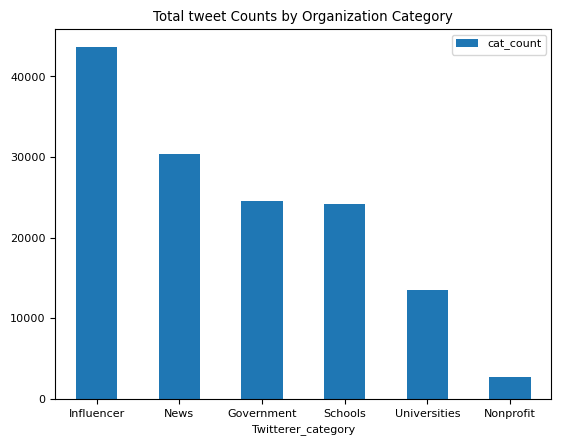

In [76]:
# Since there are too many 'someone else'category, I further filtered the data and plotted the data which 
# exclude 'someone else'category
category_1 = category.drop(index=0)
plt.rcParams.update({'font.size':8})
category_1.plot(kind='bar',x='Twitterer_category', y='cat_count',title = 'Total tweet Counts by Organization Category')
plt.xticks(rotation = 0)

In [7]:
category_re = cleandata1.filter(cleandata1.retweeted == 'RT')
category_re = category_re.groupby('Twitterer_category').\
                      agg(sum('retweetcount').alias('retweet_count')).\
                      orderBy('retweet_count', ascending=False)

In [8]:
category_re = category_re.toPandas()

In [9]:
category_re

,Twitterer_category,retweet_count
0,Someone else,1292046343
1,Influencer,16061422
2,Government,12752598
3,News,7283500
4,Schools,4350345
5,Universities,4288082
6,Nonprofit,822878


##### Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Influencer'),
  Text(1, 0, 'Government'),
  Text(2, 0, 'News'),
  Text(3, 0, 'Schools'),
  Text(4, 0, 'Universities'),
  Text(5, 0, 'Nonprofit')])

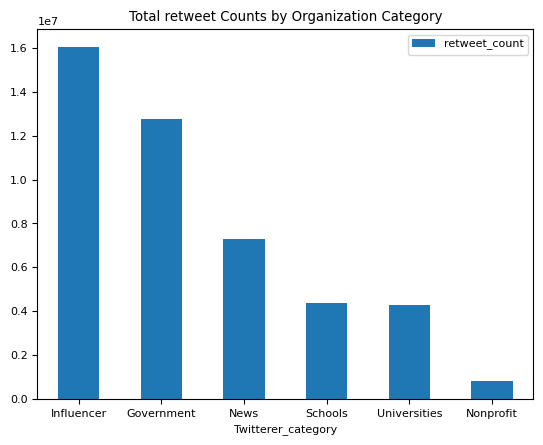

In [12]:
# Since there are too many 'someone else'category, I further filtered the data and plotted the data which 
# exclude 'someone else'category
category_1_re = category_re.drop(index=0)
plt.rcParams.update({'font.size':8})
category_1_re.plot(kind='bar',x='Twitterer_category', y='retweet_count',title = 'Total retweet Counts by Organization Category')
plt.xticks(rotation = 0)

## Location Analysis
#### Where are these Twitterers (all of them, not just influencers) located?
#### Visualize the geographical distribution

In [24]:
locationorder1 = clean_data.groupby('country').\
                agg((count('*')).alias('locationcount')).\
                orderBy('locationcount',ascending = False)

In [25]:
locationorderdf = locationorder1.toPandas()

In [26]:
location_show = locationorderdf.head(9)
location_show

,country,locationcount
0,None,1046759
1,United States,3900
2,United Kingdom,570
3,Canada,216
4,Nigeria,134
5,India,127
6,Australia,106
7,South Africa,80
8,Ireland,69


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'United Kingdom'),
  Text(2, 0, 'Canada'),
  Text(3, 0, 'Nigeria'),
  Text(4, 0, 'India'),
  Text(5, 0, 'Australia'),
  Text(6, 0, 'South Africa'),
  Text(7, 0, 'Ireland')])

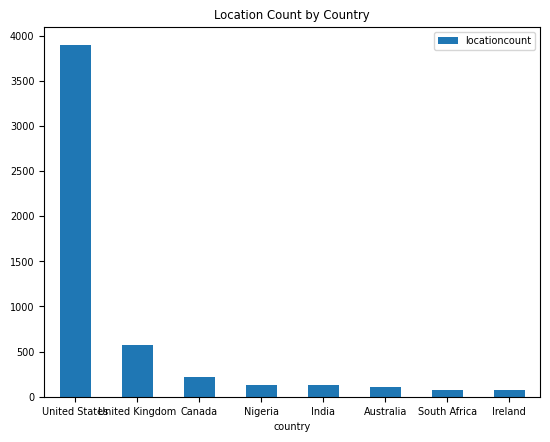

In [19]:
location_show1 = location_show.drop(index=0)
plt.rcParams.update({'font.size':7})
location_show1.plot(kind='bar',x='country', y='locationcount',title = 'Location Count by Country')
plt.xticks(rotation = 0)


In [39]:
location_filt = clean_data.filter((clean_data.country=='United States')|(clean_data.country=='United Kingdom')|\
                                    (clean_data.country=='Canada')|(clean_data.country=='Nigeria')|\
                                    (clean_data.country=='India')|(clean_data.country=='Australia'))
location_time = location_filt.groupby('stdate','country').agg(count('*').alias('count_tweets')).orderBy('stdate',ascending = True)

In [40]:
location_time

stdate,country,count_tweets
20220405,United States,18
20220405,United Kingdom,2
20220406,Canada,2
20220406,United Kingdom,2
20220406,Australia,1
20220406,United States,24
20220407,India,1
20220407,United States,16
20220407,United Kingdom,3
20220408,United Kingdom,3


In [ ]:
location_time_df=location_time.toPandas()

In [42]:
location_time_df

,stdate,country,count_tweets
0,20220405,United Kingdom,2
1,20220405,United States,18
2,20220406,United States,24
3,20220406,Australia,1
4,20220406,United Kingdom,2
...,...,...,...
803,20221105,United Kingdom,1
804,20221105,United States,16
805,20221105,Canada,1
806,20221106,United States,16


In [43]:
import pandas as pd
import numpy as np
locationnew = location_time_df.copy()
locationnew['stdate'] = pd.to_datetime(locationnew['stdate'])
locationnew['month_converted']= np.where(((locationnew['stdate']>='2022-04-05')&(locationnew['stdate']<='2022-05-05')), 'April',\
                            np.where(((locationnew['stdate']>='2022-05-06')&(locationnew['stdate']<='2022-06-05')), 'May',\
                            np.where(((locationnew['stdate']>='2022-06-06')&(locationnew['stdate']<='2022-07-05')), 'June',\
                            np.where(((locationnew['stdate']>='2022-07-06')&(locationnew['stdate']<='2022-08-05')), 'July',\
                            np.where(((locationnew['stdate']>='2022-08-06')&(locationnew['stdate']<='2022-09-05')), 'August',\
                            np.where(((locationnew['stdate']>='2022-09-06')&(locationnew['stdate']<='2022-10-05')), 'September',\
                            np.where(((locationnew['stdate']>='2022-10-06')&(locationnew['stdate']<='2022-11-06')), 'October','other')))))))
                                    
#timenew = timenew[timenew['month_converted']=='May']
locationnew.head(500)

,stdate,country,count_tweets,month_converted
0,2022-04-05,United Kingdom,2,April
1,2022-04-05,United States,18,April
2,2022-04-06,United States,24,April
3,2022-04-06,Australia,1,April
4,2022-04-06,United Kingdom,2,April
...,...,...,...,...
495,2022-08-19,India,1,August
496,2022-08-19,United Kingdom,3,August
497,2022-08-20,United States,22,August
498,2022-08-20,Australia,1,August


In [44]:
locationnew1 = locationnew.groupby(['month_converted','country'])['count_tweets'].sum().reset_index()
locationnew1['month_in'] = pd.DatetimeIndex(pd.to_datetime(locationnew1['month_converted'], format='%B')).month
# Sort using the index
locationnew1 = locationnew1.set_index('month_in').sort_index()
locationnew1

,month_converted,country,count_tweets
month_in,,,
4,April,Australia,7
4,April,Canada,32
4,April,India,16
4,April,Nigeria,17
4,April,United Kingdom,52
4,April,United States,521
5,May,Australia,15
5,May,Canada,41
5,May,India,23


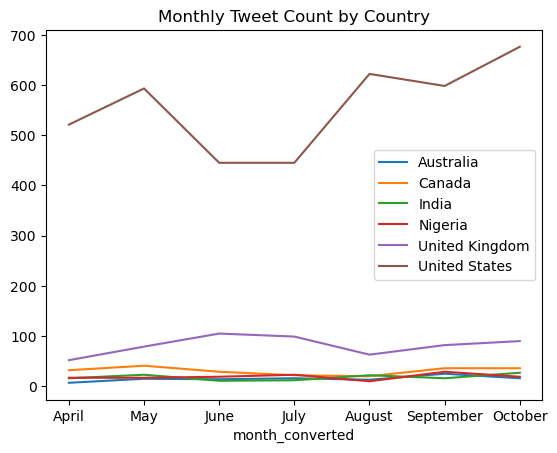

In [46]:
from matplotlib import pyplot as plt 
plt.rcParams.update({'font.size':10})
fig, ax = plt.subplots()
for label, grp in locationnew1.groupby('country'):
    grp.plot(x = 'month_converted', y = 'count_tweets',ax = ax, label = label,title='Monthly Tweet Count by Country')
    

#### What are the timelines of these tweets? Do you see significant peaks and valleys?
#### Do you see any data collection gaps?
#### Plot the timelines of these tweets

In [14]:
timeline =cleandata1.groupby('stdate','Twitterer_category').agg(count('*').\
          alias('timeline_count')).orderBy('stdate',ascending=False)

In [15]:
timelinedf = timeline.filter(timeline.Twitterer_category!= 'Someone else')

In [16]:
timelineplot = timelinedf.toPandas()

In [17]:
timelineplot

,stdate,Twitterer_category,timeline_count
0,20221106,Influencer,113
1,20221106,Nonprofit,8
2,20221106,Government,60
3,20221106,News,85
4,20221106,Schools,44
...,...,...,...
1291,20220405,News,169
1292,20220405,Government,126
1293,20220405,Influencer,211
1294,20220405,Schools,119


In [18]:
import pandas as pd
import numpy as np
timenew = timelineplot.copy()
timenew['stdate'] = pd.to_datetime(timenew['stdate'])
timenew['month_converted']= np.where(((timenew['stdate']>='2022-04-05')&(timenew['stdate']<='2022-05-05')), 'April',\
                            np.where(((timenew['stdate']>='2022-05-06')&(timenew['stdate']<='2022-06-05')), 'May',\
                            np.where(((timenew['stdate']>='2022-06-06')&(timenew['stdate']<='2022-07-05')), 'June',\
                            np.where(((timenew['stdate']>='2022-07-06')&(timenew['stdate']<='2022-08-05')), 'July',\
                            np.where(((timenew['stdate']>='2022-08-06')&(timenew['stdate']<='2022-09-05')), 'August',\
                            np.where(((timenew['stdate']>='2022-09-06')&(timenew['stdate']<='2022-10-05')), 'September',\
                            np.where(((timenew['stdate']>='2022-10-06')&(timenew['stdate']<='2022-11-06')), 'October','other')))))))
                                    
#timenew = timenew[timenew['month_converted']=='May']
timenew.head(500)

,stdate,Twitterer_category,timeline_count,month_converted
0,2022-11-06,Influencer,113,October
1,2022-11-06,Nonprofit,8,October
2,2022-11-06,Government,60,October
3,2022-11-06,News,85,October
4,2022-11-06,Schools,44,October
...,...,...,...,...
495,2022-08-16,Universities,55,August
496,2022-08-16,Nonprofit,8,August
497,2022-08-16,News,135,August
498,2022-08-15,Influencer,154,August


In [19]:
timenew1 = timenew.groupby(['month_converted','Twitterer_category'])['timeline_count'].sum().reset_index()
timenew1['month_in'] = pd.DatetimeIndex(pd.to_datetime(timenew1['month_converted'], format='%B')).month
# Sort using the index
timenew1 = timenew1.set_index('month_in').sort_index()
timenew1

,month_converted,Twitterer_category,timeline_count
month_in,,,
4,April,Government,4020
4,April,Influencer,7073
4,April,News,4921
4,April,Nonprofit,395
4,April,Schools,3772
4,April,Universities,1986
5,May,Government,4097
5,May,Influencer,7029
5,May,News,4764


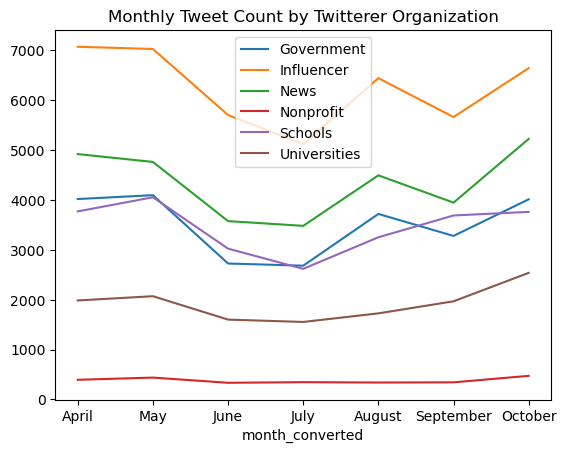

In [20]:
from matplotlib import pyplot as plt 
plt.rcParams.update({'font.size':10})
fig, ax = plt.subplots()
for label, grp in timenew1.groupby('Twitterer_category'):
    grp.plot(x = 'month_converted', y = 'timeline_count',ax = ax, label = label,title='Monthly Tweet Count by Twitterer Organization')
    

In [25]:
timenew2 = timenew1.groupby(['month_converted'])['timeline_count'].sum().reset_index()
timenew2['month_in'] = pd.DatetimeIndex(pd.to_datetime(timenew2['month_converted'], format='%B')).month
# Sort using the index
timenew2 = timenew2.set_index('month_in').sort_index()
timenew2

,month_converted,timeline_count
month_in,,
4,April,22167
5,May,22455
6,June,16970
7,July,15806
8,August,19980
9,September,18895
10,October,22659


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'April'),
  Text(1, 0, 'May'),
  Text(2, 0, 'June'),
  Text(3, 0, 'July'),
  Text(4, 0, 'August'),
  Text(5, 0, 'September'),
  Text(6, 0, 'October')])

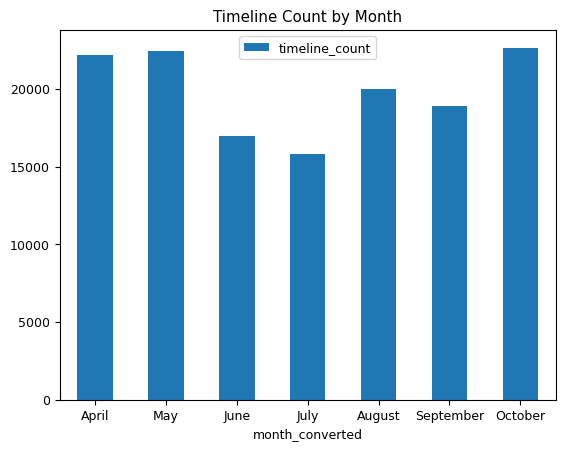

In [26]:
plt.rcParams.update({'font.size':9})
timenew2.plot(kind='bar',x='month_converted', y='timeline_count',title = 'Timeline Count by Month')
plt.xticks(rotation = 0)